![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/SWOT_L4_DAWG_SOS_DISCHARGE.ipynb).

# Exploring river discharge in the SWORD of Science (SoS) dataset
#### *Author: Nikki Tebaldi, NASA JPL PO.DAAC*

## Summary

The SWORD of Science (SoS) is a community-driven dataset produced for and from the execution of the Confluence workflow in the cloud which enables quick data access and compute on SWOT data. Data granules contain two files, priors and results. The priors file contains prior information, such as in-situ gage data and model output that is used to generate the discharge products. The results file contains the resulting river discharge data products.

The cloud-based workflow ("Confluence") that produces the SoS will produce discharge parameter estimates which the SWOT mission will use to produce discharge. This discharge will be stored in the SWOT shapefiles as the official SWOT discharge. However, the Confluence workflow produces discharge time series alongside the discharge parameter estimates in order to preview what will eventually stored in the SWOT shapefiles. Users can reference the SoS for the latest discharge time series recognizing that the official SWOT discharge data product lives in the SWOT shapefiles.

The SoS is organized by continent following [SWOT River Database (SWORD)](https://www.swordexplorer.com/) structure and naming conventions. It is indexed on the same reach and node identifier dimensions found in SWORD. Time series data is stored by cycle and pass on an observation dimension.


More information is available in the SWOT-Confluence Github repository:
* [Documentation for priors](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-priors.pdf)
* [Documentation for results](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-results.pdf)


Results are organized into groups corresponding to modules in the SWOT-Confluence processing software. Modules are described in the [Confluence Module Documentation](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_module_documentation_v1.0.pdf).

### Table of Modules (Algorithms) and Discharge variables

The following lists the algorithms alongside their discharge variables and location in the SoS results file assuming that the SoS is an open file represented by the `results` variable. 

The first six reference discharge time series for the flow law parameter estimate (FLPE) algorithms while the last six reference the Mean Optimization Integrator (MOI) results. The MOI uses a river topology to force mass conservation at confluences to produce a discharge time series for each reach-level FLPE.

| Module (Algorithm)               | Discharge Variable               | Location in the SoS              |
|----------------------------------|----------------------------------|----------------------------------|
| HiVDI                            | Q                                | results["hivdi"]["Q"]            |
| MetroMan                         | allq                             | results["metroman"]["allq"]      |
| MOMMA                            | Q                                | results["momma"]["Q"]            |
| neoBAM                           | q1, q2, or q3                    | results["neobam"]["q"]["q1"]     |
| SAD                              | Qa                               | results["sad"]["Qa"]             |
| SIC4DVar                         | Q_mm                             | results["sic4dvar"]["Q_mm"]      |
| MOI HiVDI                        | q                                | results["moi"]["hivdi"]["q"]     |
| MOI MetroMan                     | q                                | results["moi"]["metroman"]["q"]  |
| MOI MOMMA                        | q                                | results["moi"]["momma"]["q"]     |
| MOI neoBAM                       | q                                | results["moi"]["qeobam"]["q"]    |
| MOI SAD                          | q                                | results["moi"]["sad"]["q"]       |
| MOI SIC4DVar                     | q                                | results["moi"]["sic4dvar"]["q"]  |

## Requirements

### 1. Compute environment 

This tutorial can be run in the following environments:
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

## Learning Objectives
- To explore and begin to understand the structure of the SoS.
- To locate and plot river discharge.

------

## Import Packages

In [1]:
import datetime
import pathlib

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import earthaccess
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

## Authenticate
Authenticate your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [2]:
earthaccess.login() # Login with your EDL credentials if asked

## Search and Access SoS data
Locate the SoS data of interest and then download for access.

In [3]:
# Search and locate granules
granule_info = earthaccess.search_data(
    short_name="SWOT_L4_DAWG_SOS_DISCHARGE",
    temporal=("2023-04-07", "2023-04-26"),
)
granule_info

Granules found: 3


[Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -21.794, 'SouthBoundingCoordinate': 25.382, 'EastBoundingCoordinate': 25.382, 'NorthBoundingCoordinate': 81.115}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2023-04-25T20:01:59.000Z', 'BeginningDateTime': '2023-04-07T22:49:35.000Z'}}
 Size(MB): 983.0999364852905
 Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc'],
 Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -81.139, 'South

In [4]:
# Enter a directory path to store downloaded data in
downloads_dir = pathlib.Path("data_downloads")
downloads_dir.mkdir(parents=True, exist_ok=True)

# Select a priors and results pair to explore
download_links = [[link for link in earthaccess.results.DataGranule.data_links(granule)] for granule in granule_info]
print("Select a priors and results file to explore:")
for downloads in download_links: 
    for download in downloads:
        if "priors" in download: print(download)

Select a priors and results file to explore:
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/sa_sword_v15_SOS_unconstrained_0001_20240228T205034_priors.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v15_SOS_unconstrained_0001_20240228T205032_priors.nc


In [5]:
# Select Europe ("eu") priors file to work with
priors_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc"

# Select results
results_link = priors_link.replace("priors", "results")

earthaccess.download(priors_link, downloads_dir)
earthaccess.download(results_link, downloads_dir)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File eu_sword_v15_SOS_unconstrained_0001_20240228T205029_priors.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['data_downloads/eu_sword_v15_SOS_unconstrained_0001_20240228T205029_results.nc']

In [6]:
# Open downloaded files to access SoS granule data
priors_download = priors_link.split('/')[-1]
results_download = results_link.split('/')[-1]

priors = nc.Dataset(downloads_dir.joinpath(priors_download), format="NETCDF4")
results = nc.Dataset(downloads_dir.joinpath(results_download), format="NETCDF4")

## Explore the SoS
We can now explore the SoS using either the data read directly from S3 or downloaded to your local computer.

In [7]:
# Constants

# Select a river
RIVER_NAME = "Rhine"

# Select a discharge algorithm (hivdi, neobam, metroman, momma, sad, sic4dvar)
DISCHARGE_ALGORITHM = "hivdi"
DISCHARGE_VARIABLE = "Q"

In [8]:
# Display the priors groups
print("Priors Groups:")
print(priors.groups)

Priors Groups:
{'reaches': <class 'netCDF4._netCDF4.Group'>
group /reaches:
    dimensions(sizes): 
    variables(dimensions): int64 reach_id(num_reaches), float64 x(num_reaches), float64 y(num_reaches), <class 'str'> river_name(num_reaches)
    groups: , 'nodes': <class 'netCDF4._netCDF4.Group'>
group /nodes:
    dimensions(sizes): 
    variables(dimensions): int64 node_id(num_nodes), int64 reach_id(num_nodes), float64 x(num_nodes), float64 y(num_nodes), <class 'str'> river_name(num_nodes)
    groups: , 'model': <class 'netCDF4._netCDF4.Group'>
group /model:
    dimensions(sizes): num_months(12), probability(20)
    variables(dimensions): int32 num_months(num_months), int32 probability(probability), float64 flow_duration_q(num_reaches, probability), float64 max_q(num_reaches), float64 monthly_q(num_reaches, num_months), float64 mean_q(num_reaches), float64 min_q(num_reaches), float64 two_year_return_q(num_reaches), int32 area_estimate_flag(num_reaches)
    groups: , 'gbpriors': <class

In [9]:
# Display the module groups
print("Results Groups:")
print(results.groups)

Results Groups:
{'reaches': <class 'netCDF4._netCDF4.Group'>
group /reaches:
    dimensions(sizes): 
    variables(dimensions): int64 reach_id(num_reaches), float64 x(num_reaches), float64 y(num_reaches), <class 'str'> river_name(num_reaches), int32 observations(num_reaches), float64 time(num_reaches)
    groups: , 'nodes': <class 'netCDF4._netCDF4.Group'>
group /nodes:
    dimensions(sizes): 
    variables(dimensions): int64 node_id(num_nodes), int64 reach_id(num_nodes), float64 x(num_nodes), float64 y(num_nodes), <class 'str'> river_name(num_nodes), int32 observations(num_nodes), float64 time(num_nodes)
    groups: , 'hivdi': <class 'netCDF4._netCDF4.Group'>
group /hivdi:
    dimensions(sizes): 
    variables(dimensions): float64 Q(num_reaches), float64 A0(num_reaches), float64 beta(num_reaches), float64 alpha(num_reaches)
    groups: , 'metroman': <class 'netCDF4._netCDF4.Group'>
group /metroman:
    dimensions(sizes): 
    variables(dimensions): float64 allq(num_reaches), float64 A

## Plot river reach locations
Information about the spatial location of river reaches is in the reaches and nodes groups including river names. This data is taken directly from [SWOT River Database (SWORD)](https://www.swordexplorer.com/).

In [10]:
reaches = results.groups['reaches']    # Access the reaches group

print("Reaches Group")
print(reaches, "\n")

print("Longitude")
print(reaches.variables['x'])

Reaches Group
<class 'netCDF4._netCDF4.Group'>
group /reaches:
    dimensions(sizes): 
    variables(dimensions): int64 reach_id(num_reaches), float64 x(num_reaches), float64 y(num_reaches), <class 'str'> river_name(num_reaches), int32 observations(num_reaches), float64 time(num_reaches)
    groups:  

Longitude
<class 'netCDF4._netCDF4.Variable'>
float64 x(num_reaches)
    long_name: longitude
    comment: longitude of the reach center decimal ranging from 180°E to 180°W
    units: degrees_east
    valid_min: -180.0
    valid_max: 180.0
    coverage_content_type: coordinate
path = /reaches
unlimited dimensions: 
current shape = (30768,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [11]:
# Unpack the spatial coordinates and river names
reach_lon = results.groups['reaches'].variables['x']
reach_lat = results.groups['reaches'].variables['y']

river_names = results.groups['reaches'].variables['river_name']

# Filter data to only find the river of interest
idx = np.where(river_names[:] == RIVER_NAME)
print(f"Indexes for {RIVER_NAME}:\n {idx}")

Indexes for Rhine:
 (array([12597, 12598, 12599, 12600, 12601, 12602, 12603, 12606, 12616,
       12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625,
       12626, 12627, 12628, 12629, 12630, 12631, 12634, 12635, 12636,
       12638, 12639, 12640, 12769, 12918, 12919, 12920, 12923, 12924,
       12925, 12926, 12931, 12932, 12933, 12938, 12939, 12940, 12941,
       12942, 12943, 12944, 13098, 13099, 13100, 13101, 13102, 13152,
       13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161,
       13162, 13163, 13164, 13165, 13166, 13168, 13169, 13170, 13172,
       13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181,
       13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190,
       13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199,
       13200, 13201, 13202, 13204, 13205, 13206, 13207, 13208, 13316,
       13317, 13319, 13324, 13325, 13326, 13327, 13328, 13329, 13330,
       13331, 13332, 13333, 13334, 13335, 13336, 13337, 13339, 13340,

Text(0.5, 1.0, 'Rhine Reach Centerpoint Locations')

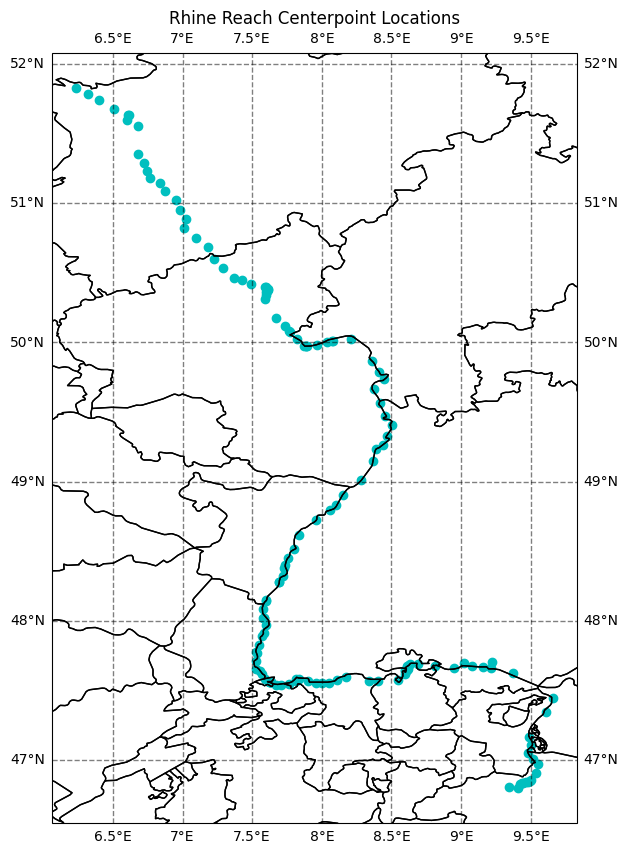

In [12]:
# Plot the location of the river
fig = plt.figure(figsize=(10,10))

# Add map elements gridlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the river reach centerpoint locations
ax.scatter(reach_lon[idx], y=reach_lat[idx], color='c')

# Add the title
plt.title(f'{RIVER_NAME} Reach Centerpoint Locations')

## Navigating Reaches and Nodes
The SoS is organized by continent following the conventions set in the [SWOT River Database](https://www.swordexplorer.com/) for the NetCDF file format. Reach identifiers can be found in the "reaches" group and node identifiers can be found in the "nodes" group. The following sections show you how to locate reaches and nodes by river name which allows you to index into the reach and/or node level data.

**How to locate reach and node identifiers by river name**

You can search for a river name using the same convention as used when plotting river reach locations to obtain the reach identifiers for that river. You can then use the reach identifiers to locate the nodes that belong to each reach for that river as the nodes are indexed on a different dimension (num_nodes) than reaches (num_reaches).

In [13]:
# Locate the indexes for the specific river you are interested in
river_names = results['reaches']['river_name'][:]
reach_idx = np.where(river_names[:] == RIVER_NAME)

# Locate the reach identifiers for the river name
reach_identifiers = results['reaches']['reach_id'][reach_idx]

# Locate the reach identifiers of interest on the node-level
reach_node_identifiers = results['nodes']['reach_id'][:]
node_idx = []
for reach_identifier in reach_identifiers:
    node_idx.extend(np.where(reach_node_identifiers == reach_identifier)[0])

# Locate the node identifiers of interest using the reach identifiers to index
node_identifiers = results['nodes']['node_id'][:]
print(f"Node identifiers: {node_identifiers}")

Node identifiers: [21101200010013 21101200010023 21101200010033 ... 29690900020221
 29690900020231 29690900030746]


In [14]:
# Unpack the spatial coordinates on the node level and index to values of interest
node_lon = results['nodes']['x'][node_idx]
node_lat = results['nodes']['y'][node_idx]
print(f"Longitude #: {node_lon.shape}")
print(f"Latitude #: {node_lat.shape}")

Longitude #: (4620,)
Latitude #: (4620,)


Text(0.5, 1.0, 'Rhine Node Centerpoint Locations')

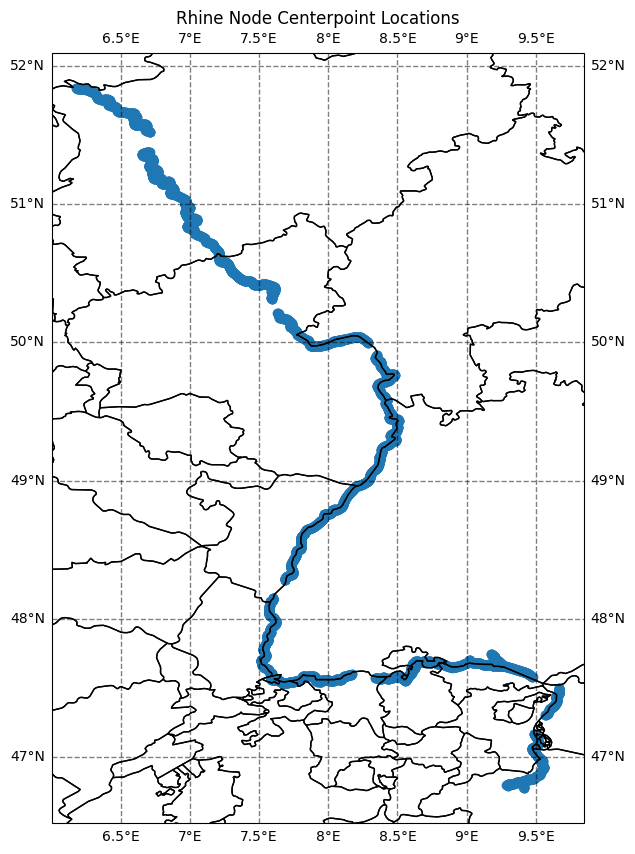

In [15]:
# Plot the nodes
fig = plt.figure(figsize=(10,10))

# Add map elements gridlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the river reach centerpoint locations
ax.scatter(x=node_lon, y=node_lat)

# Add the title
plt.title(f'{RIVER_NAME} Node Centerpoint Locations')

## Plot Discharge Timeseries
The main data of interest in the results files is the timeseries of river discharge (q) estimates produced by each module. The SoS is a global dataset organized by continents and not every reach will have an associated discharge for each module. So it is helpful to filter out missing values in order to isolate and visualize discharge for the various modules.

### How to locate data amongst missing values
You can use the `missing_value` NetCDF variable attribute to locate the value used to indicate missing data. You can then filter on that value to isolate the time steps with discharge estimates. The following example uses the HiVDI algorithm results to demonstrate filtering missing values and plotting discharge.

In [16]:
# Retrieve discharge from discharge algorithm group
discharge_algo_q = results[DISCHARGE_ALGORITHM][DISCHARGE_VARIABLE][:]

# Save the missing value
missing = results[DISCHARGE_ALGORITHM][DISCHARGE_VARIABLE].missing_value

# Loop through each reach and filter out places where the missing value is present
data_indexes = []
for i in range(discharge_algo_q.shape[0]):
    if discharge_algo_q[i].shape[0] > 1:
        if np.any(discharge_algo_q[i] != missing): data_indexes.append(i) # For multiple time steps with non-missing values
    if discharge_algo_q[i].shape[0] == 1 and discharge_algo_q[i] != missing: data_indexes.append(i)  # For one time step with non-missing value

# Display the numeric indexes where discharge data is present
print(f"10 indexes for locations that have values:\n {data_indexes[:10]}")

10 indexes for locations that have values:
 [12635, 12636, 12639, 12769, 12773, 12919, 12922, 12925, 12930, 12931]


In [17]:
reach_identifiers = results['reaches']['reach_id'][data_indexes]
print(f"10 reach identifiers for locations that have values:\n {reach_identifiers[:10]}")

10 reach identifiers for locations that have values:
 [23261000571 23261000581 23261000631 23262000011 23262000051 23263000021
 23263000051 23263000081 23263000131 23263000141]


You can now use the data indexes to retrieve location, time, and river name data about the reaches that have discharge data.

In [18]:
# Review what river names are present in the data
print("10 River Names")
print(river_names[data_indexes[:10]])

river_indexes = np.where(river_names  == RIVER_NAME)
print(f"\nIndexes for the {RIVER_NAME}")
print(river_indexes)

# Locate overlap
overlap_indexes = np.intersect1d(data_indexes, river_indexes)
print(f"\nOverlapping indexes for the {RIVER_NAME} with {DISCHARGE_ALGORITHM.upper()} Discharge data")
print(overlap_indexes)

10 River Names
['Rhine' 'Rhine' 'Rhine' 'Rhine' 'Mosel' 'Rhine' 'Lahn; Rhine' 'Rhine'
 'Lahn' 'Rhine']

Indexes for the Rhine
(array([12597, 12598, 12599, 12600, 12601, 12602, 12603, 12606, 12616,
       12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625,
       12626, 12627, 12628, 12629, 12630, 12631, 12634, 12635, 12636,
       12638, 12639, 12640, 12769, 12918, 12919, 12920, 12923, 12924,
       12925, 12926, 12931, 12932, 12933, 12938, 12939, 12940, 12941,
       12942, 12943, 12944, 13098, 13099, 13100, 13101, 13102, 13152,
       13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161,
       13162, 13163, 13164, 13165, 13166, 13168, 13169, 13170, 13172,
       13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181,
       13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190,
       13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199,
       13200, 13201, 13202, 13204, 13205, 13206, 13207, 13208, 13316,
       13317, 13319, 13324, 13325

In [19]:
# Select the first reach from the overlapping indexes
data_index = overlap_indexes[0]

# Locate the reach identifier
reach_id = reaches['reach_id'][data_index]
print(f"{RIVER_NAME} reach identifier to plot: {reach_id}")

# Retrieve discharge
discharge_algo_q = discharge_algo_q[data_index]
print(f"\nDischarge for {RIVER_NAME} reach identifier # {reach_id}")
print(discharge_algo_q)

# Retrieve time
time = results['reaches']['time'][data_index]
print(f"\nTime for {RIVER_NAME} reach identifier # {reach_id}")
print(results['reaches']['time'][data_index])

Rhine reach identifier to plot: 23261000571

Discharge for Rhine reach identifier # 23261000571
[-1.00000000e+12 -1.00000000e+12 -1.00000000e+12 -1.00000000e+12
 -1.00000000e+12 -1.00000000e+12 -1.00000000e+12 -1.00000000e+12
 -1.00000000e+12  5.40782194e+01  4.99487494e+01  3.42913882e+01
  3.44913537e+01]

Time for Rhine reach identifier # 23261000571
[7.34223036e+08 7.34308874e+08 7.34394712e+08 7.34909740e+08
 7.34995578e+08 7.35081416e+08 7.35167254e+08 7.35253092e+08
 7.35338929e+08 7.35510605e+08 7.35596443e+08 7.35682281e+08
 7.35768119e+08]


In [20]:
# Transform time to correct format
swot_ts = datetime.datetime(2000,1,1,0,0,0)
missing_time = results['reaches']['time'].missing_value
time_str = []
for t in time:
    if t == missing_time: 
        time_str.append('NO_DATA')
    else:
        time_str.append((swot_ts + datetime.timedelta(seconds=t)).strftime('%Y-%m-%dT%H:%M:%S'))
time_str = np.array(time_str)
print(f"Formatted time: {time_str}")

Formatted time: ['2023-04-07T22:50:35' '2023-04-08T22:41:13' '2023-04-09T22:31:52'
 '2023-04-15T21:35:40' '2023-04-16T21:26:18' '2023-04-17T21:16:56'
 '2023-04-18T21:07:33' '2023-04-19T20:58:11' '2023-04-20T20:48:49'
 '2023-04-22T20:30:05' '2023-04-23T20:20:43' '2023-04-24T20:11:21'
 '2023-04-25T20:01:58']


In [21]:
# Filter any missing values out of reach identifier discharge and time
missing_reach_index = np.where(discharge_algo_q != missing)

discharge_algo_q = discharge_algo_q[missing_reach_index]
print(f"Discharge for {RIVER_NAME} reach identfier # {reach_id}")
print(discharge_algo_q)

time_str = time_str[missing_reach_index]
print(f"\nTime for {RIVER_NAME} reach identfier # {reach_id}")
print(time_str)

Discharge for Rhine reach identfier # 23261000571
[54.07821944 49.94874936 34.29138816 34.49135369]

Time for Rhine reach identfier # 23261000571
['2023-04-22T20:30:05' '2023-04-23T20:20:43' '2023-04-24T20:11:21'
 '2023-04-25T20:01:58']


Text(0.5, 0.98, 'Discharge Timeseries from HIVDI for the Ohio River reach identifier: 23261000571.')

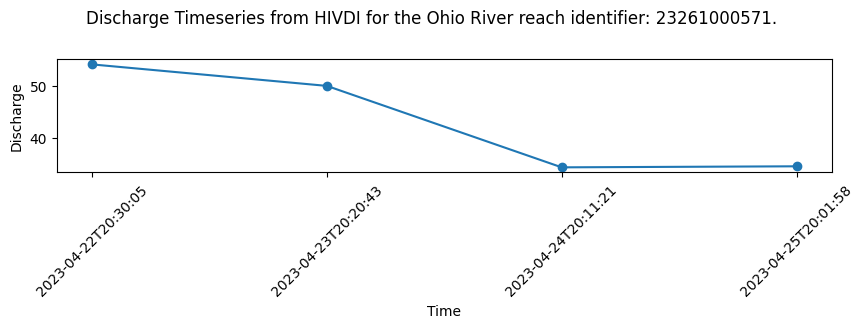

In [22]:
# Plot Discharge for the River Reach Identifier

# Set up plot
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)

# Plot data
ax1.scatter(time_str, discharge_algo_q)
ax1.plot(time_str, discharge_algo_q)

# Define labels and title
ax1.set_ylabel('Discharge')
ax1.set_xlabel('Time')
plt.xticks(rotation = 45)

plt.suptitle(f"Discharge Timeseries from HIVDI for the Ohio River reach identifier: {reach_id}.")

## Plotting integrator results for comparison
The SoS contains reach-level Flow Law Parameter (FLPE) algorithms: HiVDI, neoBAM, MetroMan, MOMMA, SAD, SIC4DVar that produce discharge estimates using SWOT observations, SoS Priors and SWORD data. It can be helpful to compare the reach-level FLPEs to the discharge values produced by the Mean Optimization Integrator (MOI). The MOI takes SWOT observation data and reach-level FLPE output and integrates the results. It uses river topology to force mass conservation and also defined uncertainty. 

In [23]:
# Locate MOI discharge results for discharge algorithm making sure to filter out missing values
moi_q = results["moi"][DISCHARGE_ALGORITHM]["q"][data_index]
moi_q = moi_q[missing_reach_index]

print(f"{DISCHARGE_ALGORITHM.upper()} MOI Discharge for {RIVER_NAME} reach identfier # {reach_id}")
print(moi_q)

HIVDI MOI Discharge for Rhine reach identfier # 23261000571
[0.0009796  0.00062748 0.00012596 0.00014881]


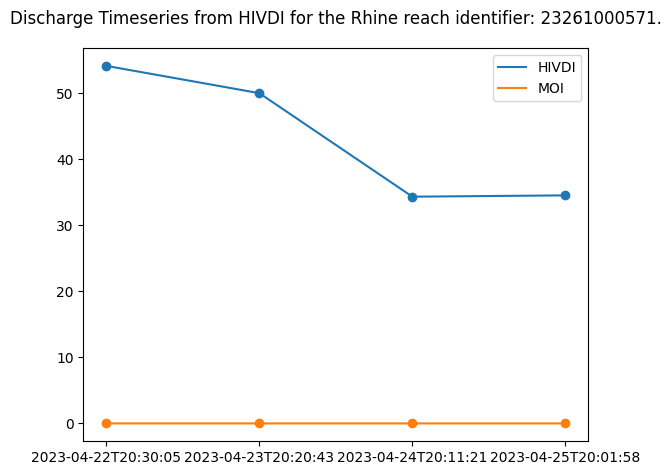

In [24]:
# Plot discharge algorithm alongside MOI discharge

# Discharge algorithm Q
plt.scatter(time_str, discharge_algo_q)
plt.plot(time_str, discharge_algo_q, label=f"{DISCHARGE_ALGORITHM.upper()}")

# MOI Q
plt.scatter(time_str, moi_q)
plt.plot(time_str, moi_q, label="MOI")

plt.suptitle(f"Discharge Timeseries from HIVDI for the {RIVER_NAME} reach identifier: {reach_id}.")
plt.legend()
plt.tight_layout()

### Close dataset and file handler references

In [25]:
priors.close()
results.close()

--------

*Disclaimer: Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*